In [1]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import torchvision
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import torch.optim as optim

import torch.nn.functional as F

import colorama
from colorama import Fore, Style

from torchsummary import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'DEVICE is : {DEVICE}')

DEVICE is : cuda


# Face Image Dataset imported

In [2]:
dataset_path = "/kaggle/input/human-face-emotions/Data"

# Analyze dataset structure to understand what files are available
def analyze_dataset(root_dir):
    structure = {}
    for root, dirs, files in os.walk(root_dir):
        rel_dir = os.path.relpath(root, root_dir)
        if rel_dir == '.':
            continue
            
        # Count files by extension
        file_counts = {}
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            if ext in file_counts:
                file_counts[ext] += 1
            else:
                file_counts[ext] = 1
                
        structure[rel_dir] = file_counts
        
    return structure

dataset_structure = analyze_dataset(dataset_path)
print("Dataset structure:")
for dir_path, file_types in dataset_structure.items():
    print(f"{dir_path}: {file_types}")

Dataset structure:
Fear: {'.png': 9714, '.jpg': 18}
Suprise: {'.png': 8004, '.jpg': 223}
Angry: {'.png': 9906, '.jpg': 242}
Sad: {'.png': 12157, '.jpg': 395, '.jpeg': 1}
Happy: {'.png': 17983, '.jpg': 364, '.jpeg': 92}


# Data Loading and Preprocessing

In [3]:
def load_image_paths(dataset_path):
    """Load image paths with corresponding labels from the dataset structure"""
    image_paths = []
    labels = []
    
    # Dictionary to map class folders to numeric labels
    class_map = {
        'Fear': 0,
        'Suprise' : 1,
        'Angry': 2,
        'Sad' : 3,
        'Happy':4,
        
    }
    
    # Iterate through each class folder
    for class_name, label in class_map.items():
        # Get all PNG images within this class
        png_path = os.path.join(dataset_path, class_name)
        
        if os.path.exists(png_path):
            png_files = glob.glob(os.path.join(png_path, '*.png'))
            
            # Add each image path with its label
            for img_path in png_files:
                image_paths.append(img_path)
                labels.append(label)
        else:
            print(f"Warning: Path {png_path} does not exist")
    
    return image_paths, labels

In [4]:
# Get image paths and labels
image_paths, labels = load_image_paths(dataset_path)

print(f"Found {len(image_paths)} images across {len(set(labels))} classes")

# Check class distribution
class_names = ['Fear', 'Suprise','Angry','Sad','Happy']

label_counts = pd.Series(labels).value_counts().sort_index()
print("Class distribution:")
for i, count in enumerate(label_counts):
    print(f"{class_names[i]}: {count} images")

Found 57764 images across 5 classes
Class distribution:
Fear: 9714 images
Suprise: 8004 images
Angry: 9906 images
Sad: 12157 images
Happy: 17983 images


# Visualize some sample images

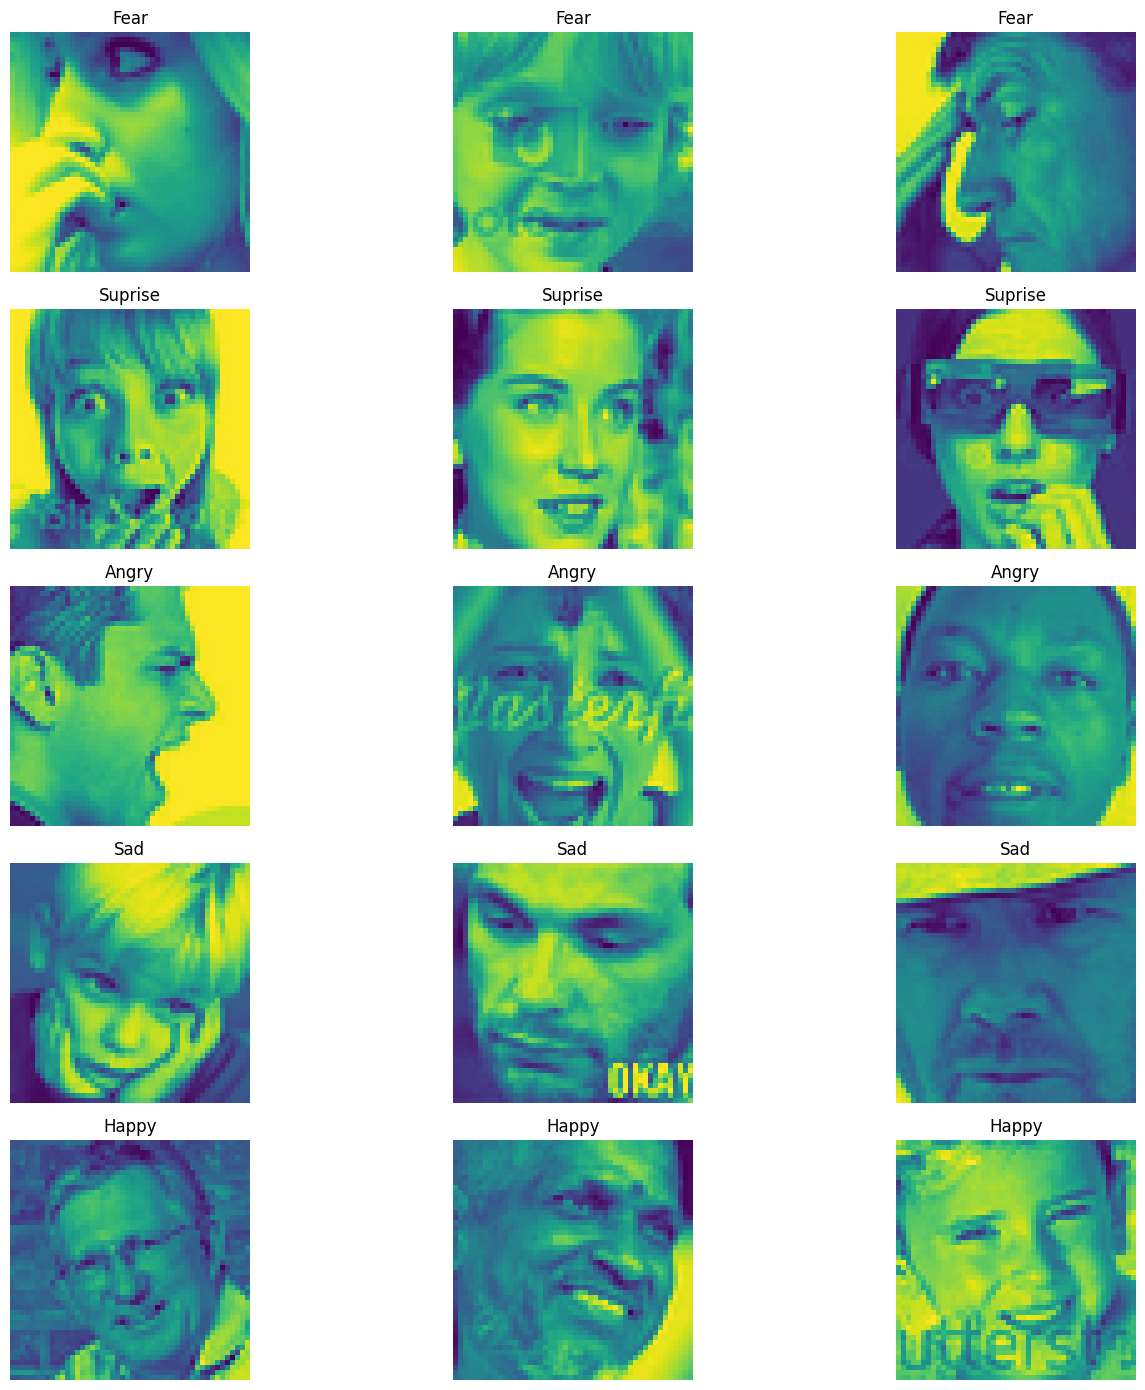

In [5]:
def show_samples(image_paths, labels, n_samples=3):
    # Get random indices for each class
    indices = {}
    for i in range(5):  # 4 classes
        class_indices = [idx for idx, label in enumerate(labels) if label == i]
        if len(class_indices) >= n_samples:
            indices[i] = np.random.choice(class_indices, n_samples, replace=False)
        else:
            indices[i] = class_indices
    
    # Create figure
    fig, axes = plt.subplots(5, n_samples, figsize=(15, 14))
    
    for i in range(5):  # For each class
        for j in range(min(n_samples, len(indices[i]))):  # For each sample
            idx = indices[i][j]
            img = Image.open(image_paths[idx])
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_names[i])
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images
show_samples(image_paths, labels)

# Split into train and validation sets

In [6]:
# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.15, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Training set: 49099 images
Validation set: 8665 images


# Create a custom dataset

In [7]:
# Create a custom dataset class for brain CT images
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        else:
            # Basic conversion to tensor
            image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        
        # Get label
        label = self.labels[idx]
        
        return image, label

# Image Augmentation

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the data to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the data to [-1, 1]
])

In [9]:
# Create datasets
train_dataset = FaceDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FaceDataset(val_paths, val_labels, transform=val_transform)

# Create data loaders
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check a batch of data
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([40, 3, 256, 256])
Labels shape: torch.Size([40])


# Sample Image show after Augmentation

torch.Size([40, 3, 256, 256])
Augmented Image:


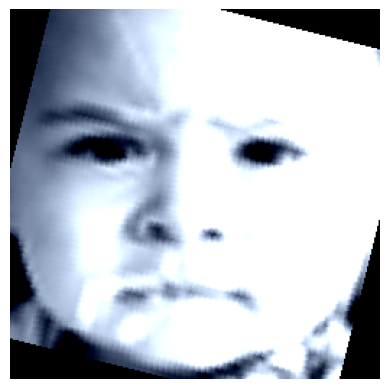

Label: Angry
Original Test Image:


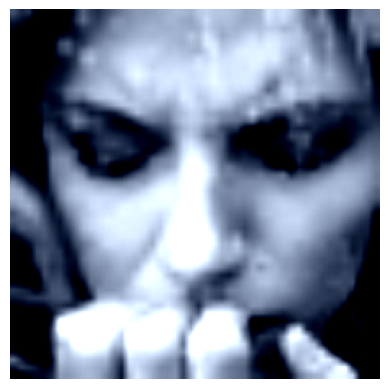

Label: Sad
Batch of Augmented Images:


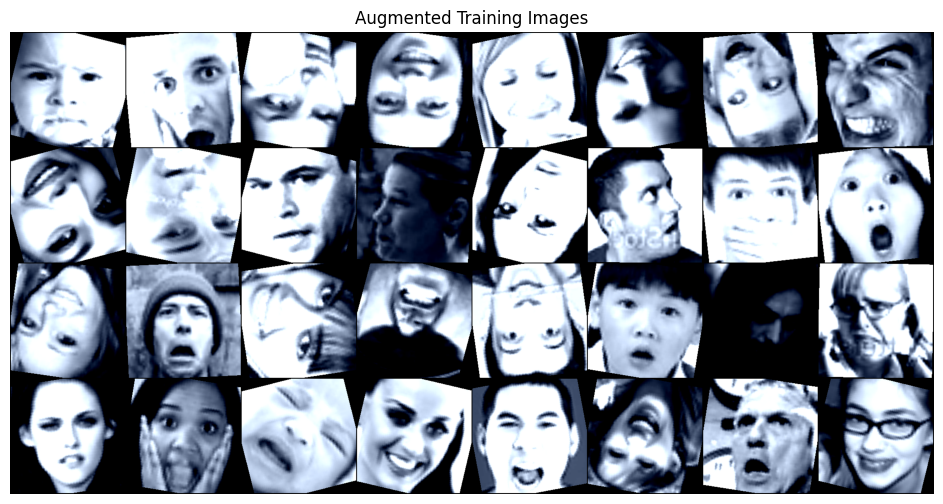

Labels: Angry Suprise Angry Happy Happy Happy Fear Angry Happy Fear Angry Sad Sad Suprise Suprise Suprise Happy Sad Happy Angry Happy Suprise Sad Angry Angry Fear Sad Happy Fear Happy Angry Happy
Batch of Original Test Images:


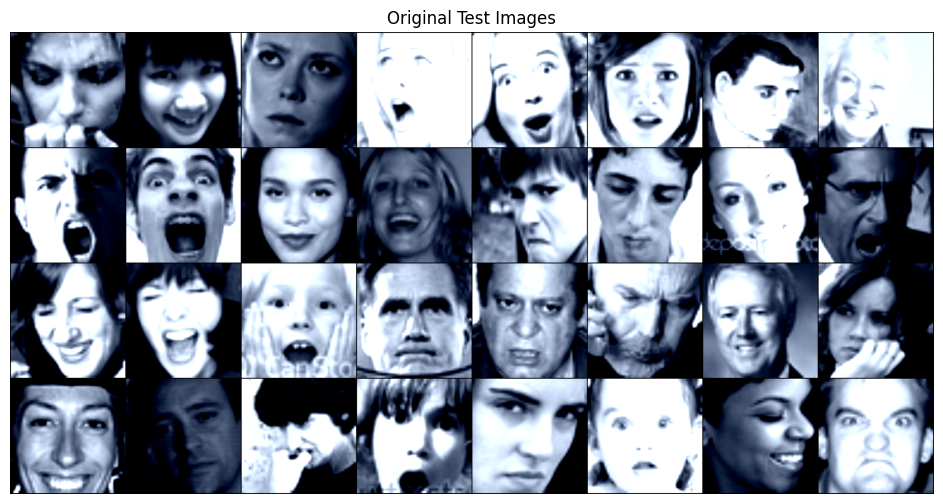

Labels: Sad Happy Sad Fear Suprise Fear Sad Happy Angry Suprise Happy Happy Angry Fear Happy Angry Happy Fear Suprise Sad Angry Angry Happy Sad Happy Sad Fear Suprise Angry Suprise Happy Angry


In [10]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# # Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# # Show one augmented image
print('Augmented Image:')
imshow(images[0])
print('Label:', class_names[labels[0]])

# Get some random test images (without augmentation)
test_dataiter = iter(val_loader)
test_images, test_labels = next(test_dataiter)

# Show one original test image
print('Original Test Image:')
imshow(test_images[0])
print('Label:', class_names[test_labels[0]])

# 3. Visualizing Augmented Images

# Function to display a batch of images
def imshow_batch(img_batch, labels_batch, title):
    img_batch = img_batch / 2 + 0.5  # Unnormalize
    npimg = torchvision.utils.make_grid(img_batch, nrow=8)
    npimg = npimg.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze())
    plt.title(title)
    plt.axis('off')
    plt.show()
    # Print labels
    print('Labels:', ' '.join(f'{class_names[labels_batch[j]]}' for j in range(len(labels_batch))))

# Display a batch of augmented images
print('Batch of Augmented Images:')
imshow_batch(images[:32], labels[:32], 'Augmented Training Images')

# Display a batch of original test images
print('Batch of Original Test Images:')
imshow_batch(test_images[:32], test_labels[:32], 'Original Test Images')

In [11]:
# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)


# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



# Moving data into GPU, WrappedDataLoader
trainloader = DeviceDataLoader(train_loader, DEVICE)
validloader = DeviceDataLoader(val_loader, DEVICE)

# # # Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

torch.Size([40, 3, 256, 256])


In [12]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        #images, labels = images.to(DEVICE), labels.to(DEVICE) # move to GPU
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        #images, labels = images.to(DEVICE), labels.to(DEVICE) # move to GPU
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

# resnet architecture 

In [15]:
# resnet architecture 
class CNN_NeuralNet(ImageClassificationBase):
    def __init__(self, in_channels, num_class):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) 
        self.conv4 = ConvBlock(256, 512, pool=True)
        #self.conv5 = ConvBlock(256, 256, pool=True)
        #self.conv6 = ConvBlock(256, 512, pool=True)
        #self.conv7 = ConvBlock(512, 512, pool=True)
        
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        # self.classifier = nn.Sequential(nn.MaxPool2d(4),
        #                                nn.Flatten(),
        #                                nn.Linear(512, num_diseases))
        
        self.classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),  # Safe replacement
                nn.Flatten(),
                nn.Linear(512, num_class)
        )
        
    def forward(self, x): # x is the loaded batch
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        #out = self.conv5(out)
        #out = self.conv6(out)
        #out = self.conv7(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        
        return out        

In [16]:
# defining the model and moving it to the GPU
# 3 is number of channels RGB, len(train.classes()) is number of diseases.
model = to_device(CNN_NeuralNet(3, len(class_names)), DEVICE) 
#model = model.to(DEVICE)
model

CNN_NeuralNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [17]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)



def get_lr(optimizer):
    if optimizer is None:
        raise ValueError("Optimizer is not defined.")
    if not optimizer.param_groups:
        raise ValueError("Optimizer has no param groups.")
    else:
        for param_group in optimizer.param_groups:
            return param_group['lr']

In [18]:
%%time
history = [evaluate(model, validloader)]
history

CPU times: user 37.2 s, sys: 2.25 s, total: 39.4 s
Wall time: 40.3 s


[{'val_loss': 1.6160855293273926, 'val_acc': 0.13864055275917053}]

# Hyperparameters Function
- Now it's time to create a function that get epochs, learning rate, train and validation loader and optim function..

- Clear GPU memory after PyTorch model training without restarting kernel with torch.cuda.empty_cache()

In [19]:
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []  #For collecting the results
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    #Sets the learning rate of each parameter group according to the 1cycle learning rate policy. 
    #The 1cycle policy anneals the learning rate from an initial learning rate to some 
    #maximum learning rate and then from that maximum learning rate to some minimum learning rate
    #much lower than the initial learning rate. 
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,
                                                epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            #Clip the gradients of an iterable of parameters at specified value.
            #All from pytorch documantation.
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
             # validation
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    torch.save(model.state_dict(), 'resnet_Model.pth')
    return history

# Training Model
Evaluate function added to history of model.

Then we can define our hyperparameters like number of epochs, learning rate and ... .

Now we can update history with fit_OneCycle function (Adding two function together). Attention to history = [] in the second function. Now we have model evaluation.

In [20]:
num_epoch = 50
lr_rate = 0.001
grad_clip = 0.15
weight_decay = 1e-4
optims = torch.optim.AdamW

history = fit_OneCycle(num_epoch, lr_rate, model, trainloader, validloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=optims)

Epoch 1/50: 100%|██████████| 1228/1228 [11:05<00:00,  1.85it/s]


Epoch [0], train_loss: 1.3435, val_loss: 1.3487, val_acc: 0.4777


Epoch 2/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [1], train_loss: 1.0855, val_loss: 1.1442, val_acc: 0.5551


Epoch 3/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [2], train_loss: 1.0131, val_loss: 1.0794, val_acc: 0.5421


Epoch 4/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [3], train_loss: 0.9735, val_loss: 1.2380, val_acc: 0.5224


Epoch 5/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [4], train_loss: 0.9556, val_loss: 0.9359, val_acc: 0.6248


Epoch 6/50: 100%|██████████| 1228/1228 [11:08<00:00,  1.84it/s]


Epoch [5], train_loss: 0.9333, val_loss: 1.0511, val_acc: 0.5841


Epoch 7/50: 100%|██████████| 1228/1228 [11:08<00:00,  1.84it/s]


Epoch [6], train_loss: 0.9169, val_loss: 0.9418, val_acc: 0.6248


Epoch 8/50: 100%|██████████| 1228/1228 [11:08<00:00,  1.84it/s]


Epoch [7], train_loss: 0.8992, val_loss: 1.7993, val_acc: 0.4177


Epoch 9/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [8], train_loss: 0.8821, val_loss: 0.8610, val_acc: 0.6558


Epoch 10/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [9], train_loss: 0.8640, val_loss: 0.8958, val_acc: 0.6592


Epoch 11/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [10], train_loss: 0.8453, val_loss: 0.8386, val_acc: 0.6705


Epoch 12/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [11], train_loss: 0.8230, val_loss: 0.9231, val_acc: 0.6493


Epoch 13/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [12], train_loss: 0.8038, val_loss: 0.7823, val_acc: 0.6872


Epoch 14/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [13], train_loss: 0.7772, val_loss: 0.8039, val_acc: 0.6832


Epoch 15/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [14], train_loss: 0.7493, val_loss: 0.7726, val_acc: 0.6945


Epoch 16/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [15], train_loss: 0.7241, val_loss: 0.8010, val_acc: 0.6951


Epoch 17/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [16], train_loss: 0.6915, val_loss: 0.7126, val_acc: 0.7172


Epoch 18/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [17], train_loss: 0.6609, val_loss: 0.7327, val_acc: 0.7131


Epoch 19/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [18], train_loss: 0.6305, val_loss: 0.6392, val_acc: 0.7490


Epoch 20/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [19], train_loss: 0.5999, val_loss: 0.6336, val_acc: 0.7503


Epoch 21/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [20], train_loss: 0.5715, val_loss: 0.7060, val_acc: 0.7229


Epoch 22/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [21], train_loss: 0.5384, val_loss: 0.5978, val_acc: 0.7703


Epoch 23/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [22], train_loss: 0.5092, val_loss: 0.6327, val_acc: 0.7635


Epoch 24/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [23], train_loss: 0.4786, val_loss: 0.5857, val_acc: 0.7775


Epoch 25/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [24], train_loss: 0.4478, val_loss: 0.6678, val_acc: 0.7593


Epoch 26/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [25], train_loss: 0.4176, val_loss: 0.5960, val_acc: 0.7870


Epoch 27/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [26], train_loss: 0.3856, val_loss: 0.5260, val_acc: 0.8128


Epoch 28/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [27], train_loss: 0.3610, val_loss: 0.5063, val_acc: 0.8183


Epoch 29/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [28], train_loss: 0.3325, val_loss: 0.5055, val_acc: 0.8228


Epoch 30/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [29], train_loss: 0.2999, val_loss: 0.4759, val_acc: 0.8406


Epoch 31/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [30], train_loss: 0.2821, val_loss: 0.4766, val_acc: 0.8451


Epoch 32/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [31], train_loss: 0.2570, val_loss: 0.4344, val_acc: 0.8529


Epoch 33/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [32], train_loss: 0.2375, val_loss: 0.4074, val_acc: 0.8629


Epoch 34/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [33], train_loss: 0.2120, val_loss: 0.4043, val_acc: 0.8700


Epoch 35/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [34], train_loss: 0.1972, val_loss: 0.3871, val_acc: 0.8787


Epoch 36/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [35], train_loss: 0.1794, val_loss: 0.3718, val_acc: 0.8843


Epoch 37/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [36], train_loss: 0.1632, val_loss: 0.3618, val_acc: 0.8878


Epoch 38/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [37], train_loss: 0.1493, val_loss: 0.3390, val_acc: 0.8962


Epoch 39/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [38], train_loss: 0.1361, val_loss: 0.3342, val_acc: 0.8994


Epoch 40/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [39], train_loss: 0.1231, val_loss: 0.3203, val_acc: 0.9067


Epoch 41/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [40], train_loss: 0.1124, val_loss: 0.3024, val_acc: 0.9156


Epoch 42/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [41], train_loss: 0.1050, val_loss: 0.2993, val_acc: 0.9162


Epoch 43/50: 100%|██████████| 1228/1228 [11:07<00:00,  1.84it/s]


Epoch [42], train_loss: 0.0970, val_loss: 0.2860, val_acc: 0.9201


Epoch 44/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [43], train_loss: 0.0900, val_loss: 0.2857, val_acc: 0.9223


Epoch 45/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [44], train_loss: 0.0823, val_loss: 0.2765, val_acc: 0.9238


Epoch 46/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [45], train_loss: 0.0814, val_loss: 0.2765, val_acc: 0.9261


Epoch 47/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [46], train_loss: 0.0774, val_loss: 0.2736, val_acc: 0.9266


Epoch 48/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [47], train_loss: 0.0746, val_loss: 0.2731, val_acc: 0.9259


Epoch 49/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [48], train_loss: 0.0739, val_loss: 0.2702, val_acc: 0.9247


Epoch 50/50: 100%|██████████| 1228/1228 [11:06<00:00,  1.84it/s]


Epoch [49], train_loss: 0.0743, val_loss: 0.2719, val_acc: 0.9274


In [21]:
val_acc = []
val_loss = []
train_loss = []

for i in history:
    val_acc.append(i['val_acc'])
    val_loss.append(i['val_loss'])
    train_loss.append(i.get('train_loss'))

# Loss per Epochs curve

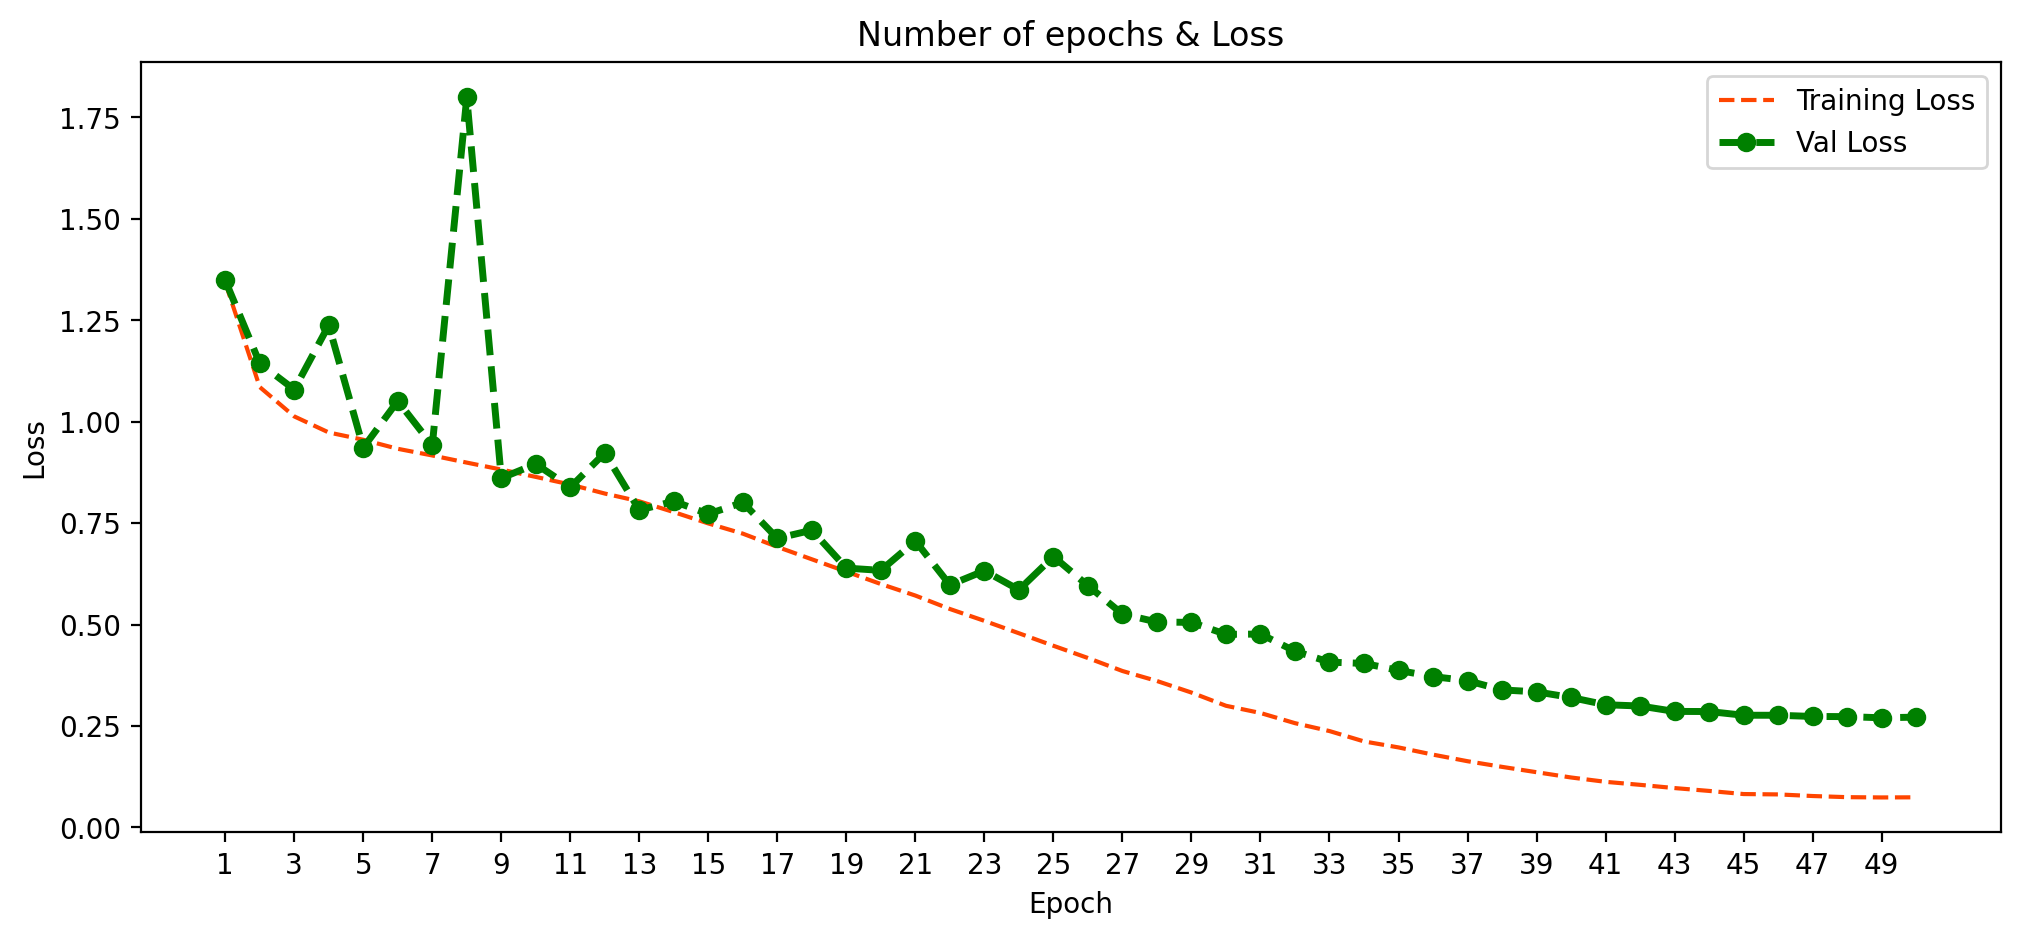

In [22]:
epoch_count = range(1,51)

plt.figure(figsize=(12,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'orangered')
plt.plot(epoch_count, val_loss, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,51,2))
plt.show();


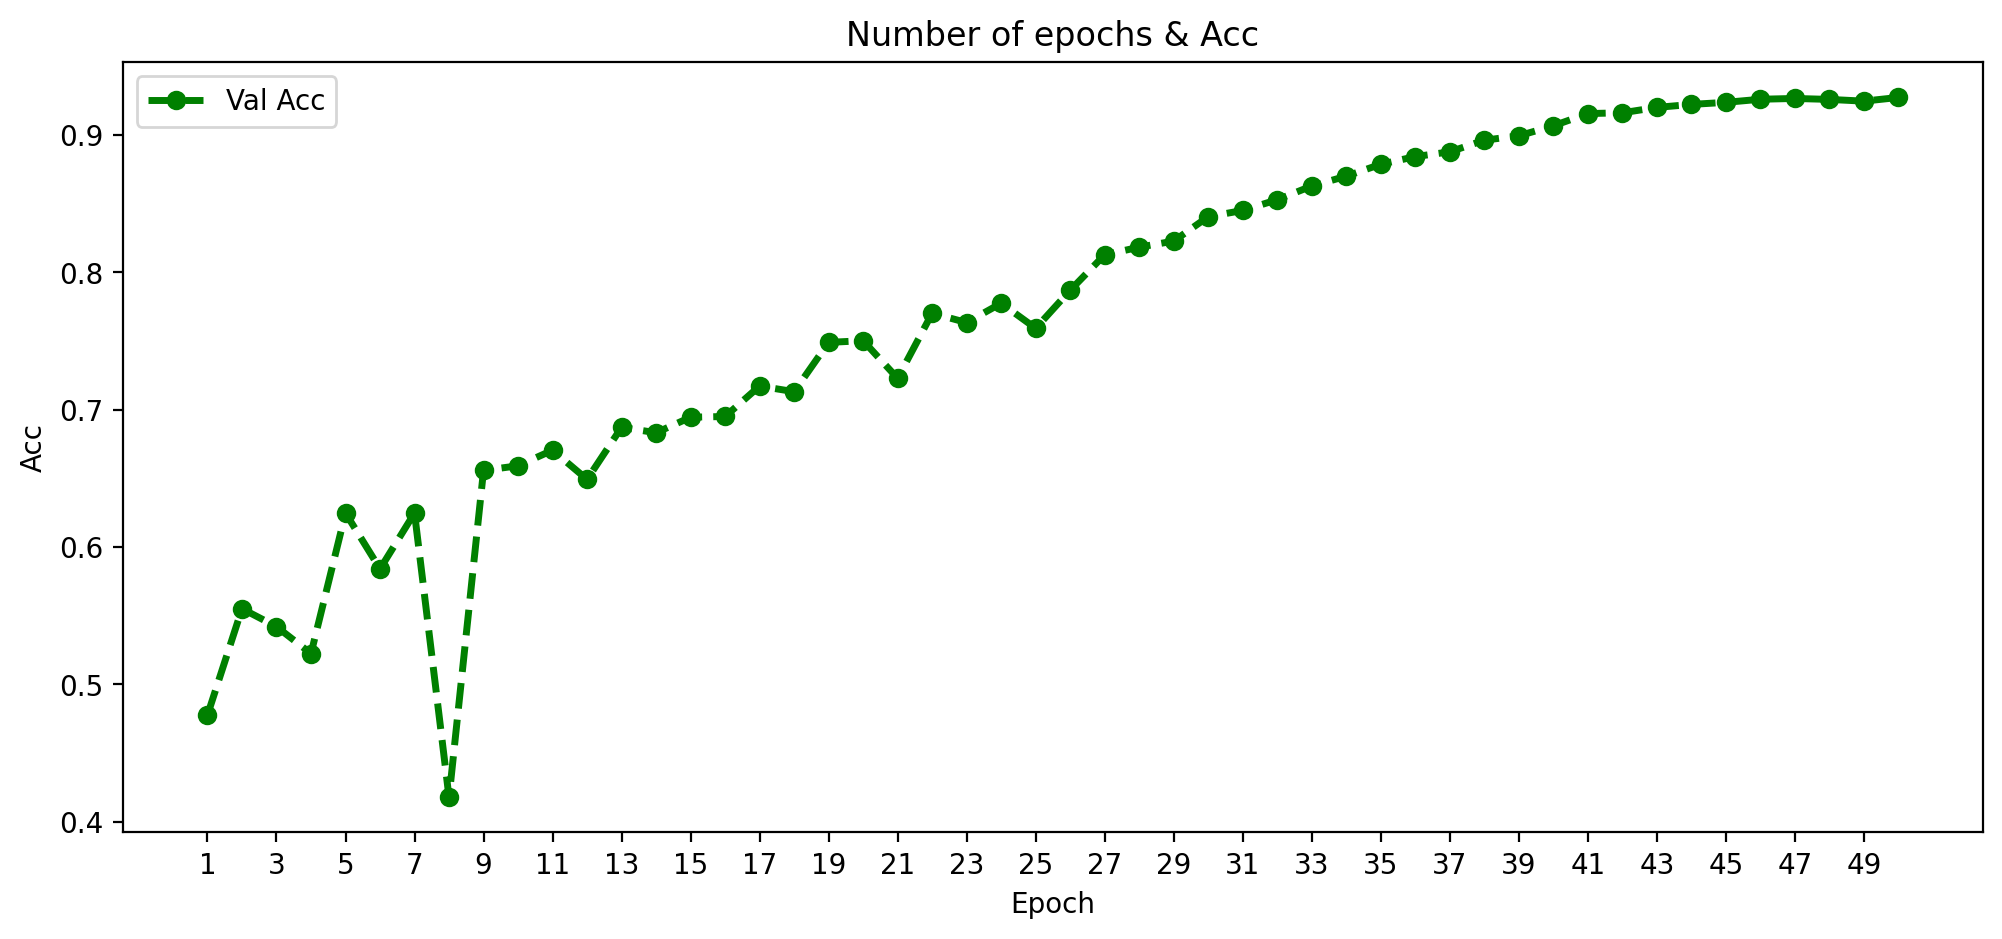

In [23]:
epoch_count = range(1,51)
plt.figure(figsize=(12,5), dpi=200)
plt.plot(epoch_count, val_acc, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Val Acc'])
plt.title('Number of epochs & Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,51,2))
plt.show();


# Visualize Model Predictions

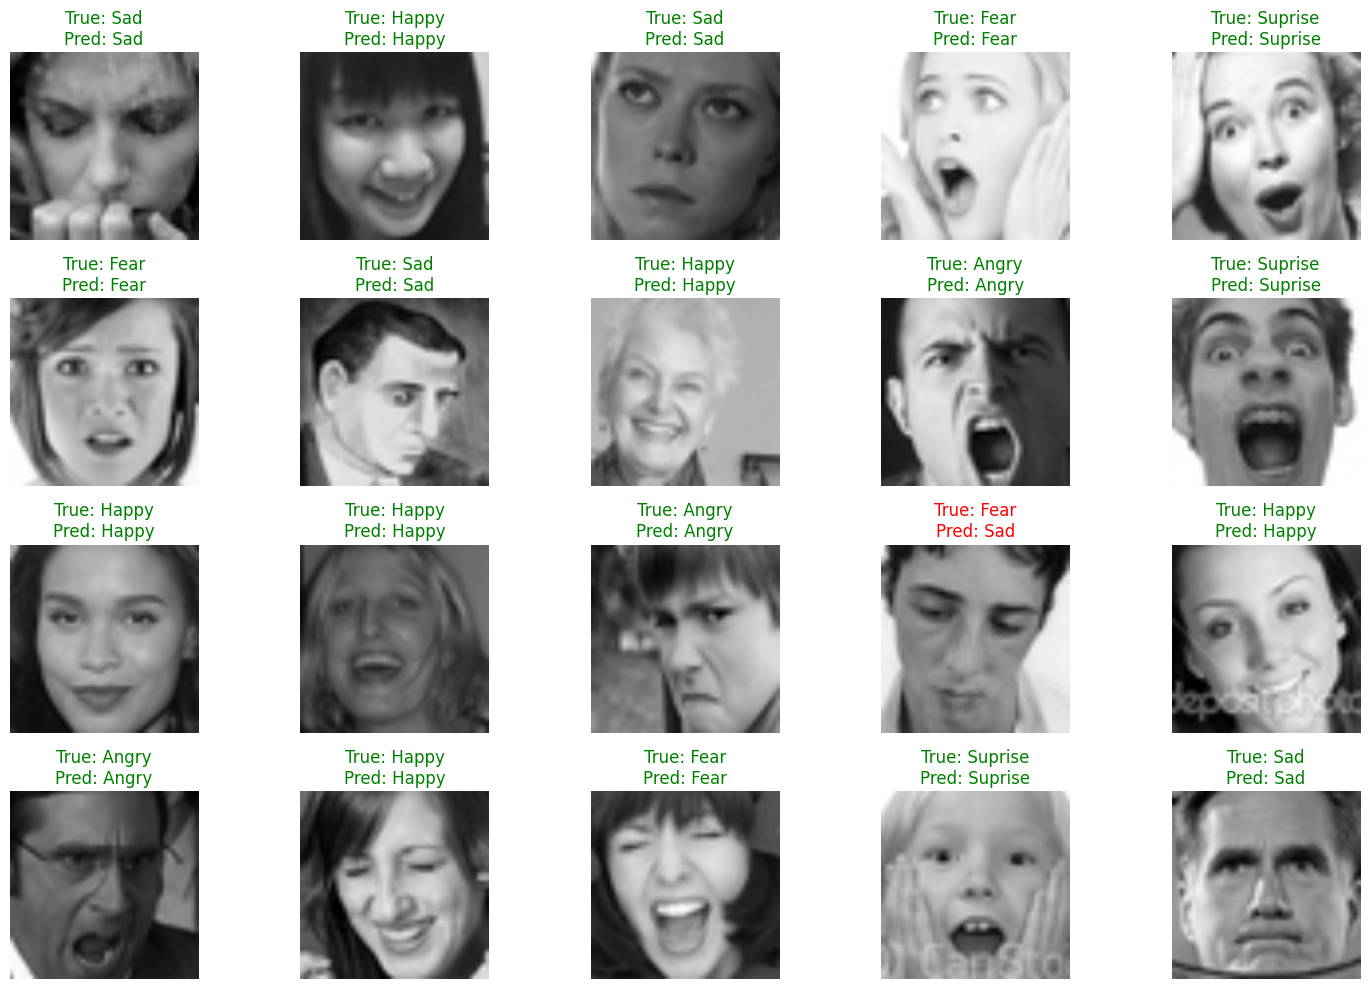

In [24]:
# Load the best model
model.load_state_dict(torch.load("resnet_Model.pth"))

def visualize_predictions(model, dataloader, class_names, num_samples=20):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            
            # Store batch data
            all_images.extend(inputs.cpu())
            all_labels.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            if len(all_images) >= num_samples:
                break
    
    # Limit to requested number of samples
    all_images = all_images[:num_samples]
    all_labels = all_labels[:num_samples]
    all_preds = all_preds[:num_samples]
    
    # Visualize
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (img, label, pred) in enumerate(zip(all_images, all_labels, all_preds)):
        if i >= len(axes):
            break
            
        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display
        axes[i].imshow(img)
        color = 'green' if label == pred else 'red'
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize some predictions
visualize_predictions(model, validloader, class_names)